# Importing Module

In [1]:
#kplr used to import koi data easier
import kplr
client = kplr.API()

#used to open .fits files
import pyfits
# import astropy

#Used for Plotting
#Experimenting with this instead of using matplot.lib
from bokeh.plotting import figure, show, output_file,output_notebook
#Allows for viewing of plots on jupyter notebooks
output_notebook()

#For Maximum Likelihood
from scipy import optimize

#Used for scientific computing
import numpy as np

#For making copies of data
import copy

#Needed to correct median with 'nan' data points
import math

#For Periodogram
from gatspy.periodic import LombScargleFast

#Importing and notebook setup
%matplotlib inline

#For Plotting
import matplotlib.pyplot as plt

Loading BokehJS ...

# Making useful functions

In [2]:
#Removes nan data points
def remove_nan(datax,datay):
    #array of nan points location in flux array
    nan_points=np.array([])
    
    #finds points that have nan as data point
    for j in range(0,len(datax)-1):
        if math.isnan(datay[j])==True:
            nan_points = np.append(nan_points,j)
    
    #deletes the points with nan and correspoding time
    datax = np.delete(datax,nan_points)
    datay = np.delete(datay,nan_points)
        
    return(datax,datay)

In [3]:
def periodogram(datax, datay, min_, max_, nyquist):
    #finding periodogram
    model = LombScargleFast().fit(datax, datay)
    period, power = model.periodogram_auto(nyquist_factor=nyquist) # Default 50

    #Plotting
    plt.figure
    plt.plot(period,power)
    plt.ylabel('Power')
    plt.xlabel('Period')# days
    plt.xscale('log')
    #used bottom line to zoom in periodogram
#     plt.xlim(min_-1,max_+10)

    # set range and find period
    model.optimizer.period_range=(min_, max_)
    period = model.best_period
    print("period = {0}".format(period))
    return period

In [4]:
#Making loop to get Median Smooth
 
#jump - The number of pixels you are taking the median
### ex. jump = 7, median over 7 points, replaces values inbetween with median
### Before: [1,2,3,4,5,6,7]
### After:  [1,4,4,4,4,4,7]


def median_smooth(flux,jump,peak_min):
    #n - determines section of data we are looking at
    n = 1
    
    #Data that is being changed and smoothed
    smooth_flux = copy.copy(flux)

    #median smoothing loop
    while n <= len(smooth_flux)-jump-1:    
        #delta of data from one point to another
        #used in for loop to leave troughs unchanged
        max_change = 0
        #Checks the max delta of data points for each jump
        for i in range (n-1,n+jump-1):
            delta = abs( flux[i]-flux[i+1])
            if delta > max_change:
                max_change = delta

        #Makes range of points equal to median
        if max_change < peak_min:
            median = np.median(flux[n-1:n+jump])
            
            #This line corrects errors with data labeled at 'nan'
            if math.isnan(median)==False:
                smooth_flux[n:n+jump-2] = median

#             #Leaves points unchaged when median is 'nan'
#             else:
#                 print 'Median: ', median
#                 print 'Data Numbers Reserved: ', n-1, ' to ', n+jump-1
#                 print 'Original Data: ', flux[n-1:n+jump]
#                 print 'Smooth Data: ', smooth_flux[n-1:n+jump]
#                 print 'Max Change: ', max_change
#                 print ''
#                 print ''
# 
#         #Leaves troughs unchaged
#         else:
#             print 'Data Numbers Reserved: ', n-1, ' to ', n+jump-1
#             print 'Original Data: ', flux[n-1:n+jump]
#             print 'Smooth Data: ', smooth_flux[n-1:n+jump]
#             print 'Max Change: ', max_change
#             print ''
#             print ''
        n=n+jump
    print 'First 100 Points'
    print 'Before: '
    print ''
    print flux[0:99]
    print ''
    print 'After: '
    print ''
    print smooth_flux[0:99]
    return smooth_flux


Loop that finds period of troughs in light curve

In [5]:
### Step 1: Make a cut_off and only look at that data
### Step 2: Find min flux of each trough
### Step 3: Find the avg. time diff between each local min
###Still need to makes this plot into a function and then will place it up above

def find_period(flux,cut_off):
    # cut_off is the max the point can be to pass the filter
    # f_change - change in flux from cutoff
#     cut_off = 69200
    min_f = np.array([])
    min_t = np.array([])

    #Step 1: filters data to just the points below the cut_off
    for i in range(0,len(flux)):
        f_change = flux[i] - cut_off

        #checks if it's lower than cut off
        if f_change < 0:
            min_f = np.append(min_f,[flux[i]])
            min_t = np.append(min_t,[t[i]])

    # print min_f
    # print min_t

    #local_min - lowest point of troughs place holder
    #check - checks to see if new point is lower than previous local_min
    local_min = min_f[0]
    troughs_f = np.array([])
    troughs_t = np.array([])

    #Step 2: filters to just show only the lowest point of each trough
    for i in range(0,len(min_f)-1):
        t_change = min_t[i+1] - min_t[i]
        check = min_f[i]
        # checks if it's lower than previous local_min
        if check < local_min:
            local_min = check
            ndata = i

        #documents lowest point and resets check for next trough
        if t_change > 1 or i > len(min_f)-3:
            troughs_f = np.append(troughs_f, [local_min])
            troughs_t = np.append(troughs_t, [min_t[ndata]])
            local_min = cut_off

    # print 'The min of each flux trough: ', troughs_f
    # print 'The corresponding time for each trough: ' ,troughs_t

    all_periods = np.array([])

    #Step 3: finding average change in time from each trough
    for i in range(0,len(troughs_t)-1):
        period = troughs_t[i+1]-troughs_t[i]
        all_periods = np.append(all_periods,period)

    avg_period = np.mean(all_periods)
    # print 'All periods: ', all_periods
#     print 'Avg. period: ', avg_period, ' days.'

    return avg_period

# Importing Data

In [6]:
# Find a KOI.
koi = client.koi(17.01)

#period, period error (postive & negative)
print 'Period w/ errors: ',(koi.koi_period, koi.koi_period_err1, koi.koi_period_err2)

# This KOI has an associated star.
star = koi.star
print star
print "Associated Star Temperature: ",(star.kic_teff)

#Download the lightcurves for this KOI.
lightcurves = koi.get_light_curves()
# for lc in lightcurves:
#     print (lc.filename)

Period w/ errors:  (0.00078, -0.00078, None)
<Star(10874614)>
Associated Star Temperature:  None


Getting Like Curve Data

In [7]:
# Loop over the datasets and read in the data.
time, flux, ferr, quality = [], [], [], []
for lc in lightcurves:
    with lc.open() as f:
        # The lightcurve data are in the first FITS HDU.
        hdu_data = f[1].data
        time.append(hdu_data["time"])
        flux.append(hdu_data["PDCSAP_FLUX"])
        ferr.append(hdu_data["PDCSAP_FLUX_ERR"])
        quality.append(hdu_data["sap_quality"])

Plotting Data

In [8]:
#Time (BJD - 2454833)
#Flux (e-/sec) + ____e+4
#Which quarter do you want to look at?
quarter =1
t = time[quarter]
f = flux[quarter]
#Creating new plot with title and axis labels
#Plot is an object
lc_plot_17 = figure(
    title='KOI-17: Quarter %d '% quarter, 
    x_axis_label='Time (BJD - 2454833)',
    y_axis_label='Flux (e-/sec) e+4',
    tools = 'hover,crosshair,pan,wheel_zoom,box_zoom,reset,tap,save,box_select')

#adding x and y data for plot
legend = 'KOI: Quarter %d' % quarter
lc_plot_17.line(t, f,legend=legend)

#showing results
show(lc_plot_17)

Median Smoothing

In [9]:
smooth_flux = median_smooth(f,5,300)

First 100 Points
Before: 

[ 73603.9765625  73619.9296875  73624.5625     73640.40625    73624.0234375
  73623.3359375  73620.6953125  73627.7421875  73632.0390625  73623.265625
  73629.265625   73609.7734375  73633.40625    73620.4921875  73618.2578125
  73632.828125   73629.171875   73611.4296875  73625.4765625  73641.921875
  73605.390625   73641.578125   73618.7109375  73618.96875    73651.3125
  73625.59375    73635.6640625  73631.4453125  73623.890625   73616.765625
  73636.875      73617.7109375  73617.2421875  73615.0625     73611.75
  73618.375      73622.5703125  73617.046875   73619.2265625  73634.3828125
  73627.2109375  73636.2734375  73612.3203125  73620.15625    73618.53125
  73631.640625   73620.1953125  73624.5859375  73625.4140625  73637.6015625
  73631.3984375  73632.703125   73635.2578125  73629.203125   73629.9921875
  73625.8125     73616.8984375  73616.484375   73624.8203125  73623.984375
  73630.390625   73626.1015625  73618.828125   73637.546875   73634.578125


C:\Users\rscsa\Anaconda2\lib\site-packages\ipykernel\__main__.py:24: RuntimeWarning: invalid value encountered in greater
C:\Users\rscsa\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


Median Smoothing of Data

In [10]:
#Plot is an object
lc_smooth_17 = figure(
    title='KOI-17', 
    x_axis_label='Time (BJD - 2454833)',
    y_axis_label='Flux (e-/sec) e+4',
    tools = 'hover,crosshair,pan,wheel_zoom,box_zoom,reset,tap,save,box_select')

#adding x and y data for plot
lc_smooth_17.line(t, smooth_flux,legend='Median Smooth Data',color='orange')
# lc_smooth_17.line(t, h_flux,legend='H Data',color='red')

print smooth_flux[180:200]
show(lc_smooth_17)

[ 73618.2578125  73619.515625   73619.515625   73619.515625   73614.5390625
  73609.3046875  73612.171875   73612.171875   73612.171875   73615.046875
  73603.8515625  73611.40625    73611.40625    73611.40625    73598.640625
  73625.2421875  73626.109375   73626.109375   73626.109375   73707.0546875]


Finding Period of Transit

In [11]:
t_no_nan, f_no_nan = remove_nan(t,f)

Finding optimal frequency:
 - Estimated peak width = 0.188
 - Using 5 steps per peak; omega_step = 0.0375
 - User-specified period range:  0.5 to 30
 - Computing periods at 331 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 1.61871988891


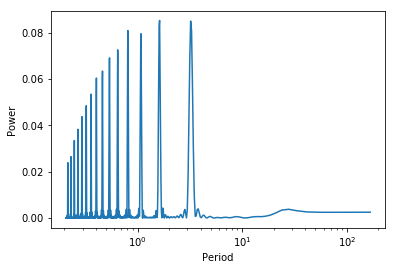

In [12]:
## Still need to work on Periodogram
### Maybe be looking for sinusoidal patterns
period = periodogram(t_no_nan, f_no_nan, .5,30,.2)

In [13]:
period = find_period(smooth_flux,73500)  
print period

3.23316453419


In [14]:
#### Copying code from: https://ridlow.wordpress.com/category/ipython-notebook/
import matplotlib.pyplot as plt
import numpy as np
import math
# t - time is an N-dimensional array of timestamps for the light curve,
# x - flux is the N-dimensional light curve array,
# qmi is the minimum transit duration to test, and
# qma is the maximum transit duration to test.
# fmin is the minimum frequency to test,
# df is the frequency grid spacing,
# nb is the number of bins to use in the folded light curve,
# nf is the number of frequency bins to test,

def bls(t, x, qmi, qma, fmin, df, nf, nb):
    """Frist trial, BLS algorithm, only minor modification from author's code"""
    
    n = len(t); rn = len(x)
    #! use try
    if n != rn:
        print "Different size of array, t and x"
        return 0

    rn = float(rn) # float of n

    minbin = 5
    nbmax = 2000
    if nb > nbmax:
        print "Error: NB > NBMAX!"
        return 0

    tot = t[-1] - t[0] # total time span

    if fmin < 1.0/tot:
        print "Error: fmin < 1/T"
        return 0

    # parameters in binning (after folding)
    kmi = int(qmi*nb) # nb is number of bin -> a single period
    if kmi < 1: 
        kmi = 1
    kma = int(qma*nb) + 1
    kkmi = rn*qmi # to check the bin size
    if kkmi < minbin: 
        kkmi = minbin

    # For the extension of arrays (edge effect: transit happen at the edge of data set)
    nb1 = nb + 1
    nbkma = nb + kma
        
    # Data centering
    t1 = t[0]
    u = t - t1
    s = np.mean(x) # ! Modified
    v = x - s

    bpow = 0.0
    p = np.zeros(nf)
    # Start period search
    for jf in range(nf):
        f0 = fmin + df*jf # iteration in frequency not period
        p0 = 1.0/f0

        # Compute folded time series with p0 period
        ibi = np.zeros(nbkma)
        y = np.zeros(nbkma)
        for i in range(n):
            ph = u[i]*f0 # instead of t mod P, he use t*f then calculate the phase (less computation)
            ph = ph - int(ph)
            j = int(nb*ph) # data to a bin 
            ibi[j] = ibi[j] + 1 # number of data in a bin
            y[j] = y[j] + v[i] # sum of light in a bin
        
        # Extend the arrays  ibi()  and  y() beyond nb by wrapping
        for j in range(nb1, nbkma):
            jnb = j - nb
            ibi[j] = ibi[jnb]
            y[j] = y[jnb]

        # Compute BLS statictics for this trial period
        power = 0.0

        for i in range(nb): # shift the test period
            s = 0.0
            k = 0
            kk = 0
            nb2 = i + kma
            # change the size of test period (from kmi to kma)
            for j in range(i, nb2): 
                k = k + 1
                kk = kk + ibi[j]
                s = s + y[j]
                if k < kmi: continue # only calculate SR for test period > kmi
                if kk < kkmi: continue # 
                rn1 = float(kk)
                powo = s*s/(rn1*(rn - rn1))
                if powo > power: # save maximum SR in a test period
                    power = powo # SR value
                    jn1 = i # 
                    jn2 = j
                    rn3 = rn1
                    s3 = s

        power = math.sqrt(power)
        p[jf] = power

        if power > bpow:
            bpow = power # Save the absolute maximum of SR
            in1 = jn1
            in2 = jn2
            qtran = rn3/rn
            # depth = -s3*rn/(rn3*(rn - rn3))
            # ! Modified
            high = -s3/(rn - rn3)
            low = s3/rn3
            depth = high - low
            bper = p0
    
    # ! add
    sde = (bpow - np.mean(p))/np.std(p) # signal detection efficiency

    return bpow, in1, in2, qtran, depth, bper, sde, p, high, low

In [15]:
# t - time is an N-dimensional array of timestamps for the light curve,
# x - flux is the N-dimensional light curve array,
# qmi is the minimum transit duration to test, and
# qma is the maximum transit duration to test.
# fmin is the minimum frequency to test,
# df is the frequency grid spacing,
# nb is the number of bins to use in the folded light curve,
# nf is the number of frequency bins to test,

qmi = 0.1
qma = 0.3
fmin = 0.2
df = 0.001
nf = 1000
nb = 200
res = bls(t_no_nan, f_no_nan, qmi, qma, fmin, df, nf, nb)
print "Best SR: ", res[0], "\nIngress: ", res[1], "\nEgress: ", res[2], "\nq: ", res[3], \
"\nDepth: ", res[4], "\nPeriod: ", res[5], "\nSDE: ", res[6]


Best SR:  83.493163261 
Ingress:  174 
Egress:  194 
q:  0.100369458128 
Depth:  277.854880786 
Period:  3.22580645161 
SDE:  5.24189750936


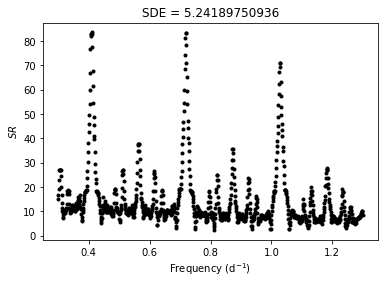

In [16]:
freq = np.arange(0.3, 1.3, 0.001)
plt.plot(freq, res[7], 'k.')
plt.title("SDE = {0}".format(res[6]))
plt.xlabel(r"Frequency (d$^{-1}$)")
plt.ylabel(r"$SR$")

# Ignore Everything Below Here

In [17]:
# #using pyfits to open a quarter of data as .fits file
# pyfits.open('c:/Users/rscsa/.kplr/data/lightcurves/010874614/kplr010874614-2009131105131_llc.fits')
# print pyfits.hdu.image.PrimaryHDU()